In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import math
import numpy as np
import random
import collections
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0').unwrapped
env.reset()

array([0.00500661, 0.01156607, 0.01283184, 0.0370254 ])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
EPISODES = 700
LR = 0.001
GAMMA = 0.999
eps = 0.99
EPS_MIN = 0.01
EPS_DECAY = 0.99
HIDDEN_LAYER1 = 32
HIDDEN_LAYER2 = 16
BATCH_SIZE = 256
NUM_ACTIONS = env.action_space.n
NUM_OBS = len(env.reset())
LIMIT = 10000
STEPS = 0
TARGET_UPDATE = 10
EPISODE_DURATION = []
REWARDS = []
AVG_OVER_100 = []
MAX_LOSS = []
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

In [5]:
class Replaymemory():
    def __init__(self, limit):
        self.limit = limit
        self.memory = []
        self.index = 0
    
    def push(self, transition):
        if(len(self.memory) < self.limit):
            self.memory.append(None)
        self.memory[self.index] = transition
        # the memory acts like a cyclic buffer
        self.index = (self.index + 1) % self.limit
        
    def sample(self, batch_size):
        # randomly samples from the memory
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.ln0 = nn.Linear(NUM_OBS, HIDDEN_LAYER1)
        self.ln1 = nn.Linear(HIDDEN_LAYER1, HIDDEN_LAYER2)
        self.ln2 = nn.Linear(HIDDEN_LAYER2, NUM_ACTIONS)
    
    def forward(self, x):
        x = F.relu(self.ln0(x))
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x

In [7]:
# Current network used to compute current q values
policy_model = Network()
# Old frozen targets
target_model = Network()
target_model.load_state_dict(policy_model.state_dict())

optimizer = optim.Adam(policy_model.parameters(), lr=LR)
# Memory buffer
memory = Replaymemory(LIMIT)

In [8]:
def epsilon_greedy_policy(state):
    prob = random.random()
    if(prob > eps):
        with torch.no_grad():
            action = policy_model(state).argmax()
    else:
        action = torch.tensor(random.randrange(NUM_ACTIONS))
    return action

In [9]:
def optimize():
    if(len(memory) < BATCH_SIZE):
        print('not enough samples available')
        return 
    trans = memory.sample(BATCH_SIZE)
    
    state_batch, action_batch, next_state_batch, reward_batch = zip(*trans)
    
    # Find non-terminating states
    is_non_terminating = torch.tensor(tuple(map(lambda s: s is not None, next_state_batch)), dtype=torch.bool)

    non_final_next_states = torch.tensor([s for s in next_state_batch if s is not None], dtype = torch.float)#.reshape(is_non_terminating.sum().item(),NUM_OBS)
    
    state_batch = torch.tensor(state_batch, dtype=torch.float)
    action_batch = torch.tensor(action_batch, dtype=torch.long)
    #next_state_batch = torch.cat(next_state_batch)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float)
    
    # Q vals calulated from the current policy network
    curr_q_vals = policy_model(state_batch).gather(1, action_batch.view(-1, 1))
    
    max_q_vals = torch.zeros(BATCH_SIZE)
    
    # Q value is 0 if next state is terminal
    max_q_vals[is_non_terminating] = target_model(non_final_next_states).max(1)[0].detach()
    
    next_q_vals = (reward_batch + (GAMMA * max_q_vals)).reshape(curr_q_vals.shape)
    
    loss = F.smooth_l1_loss(curr_q_vals,next_q_vals)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    return loss.item()

In [ ]:
# ILLUSTRATIVE PLOTS SHOWN AFTER RUNNING THE EPISODES 

In [10]:
net_reward = 0
avg_100 = 0
max_reward = 0
MAX_REWARD = []
for episode in range(EPISODES):
    
    curr_state = env.reset()
    max_loss = 0
    time_in_episode = 0
    
    while True:
        env.render()
        
        time_in_episode += 1
        
        curr_action = epsilon_greedy_policy(torch.tensor([curr_state],dtype=torch.float))
        
        if eps > EPS_MIN:
            eps *= EPS_DECAY
        else:
            eps = 0.0
        
        observation, reward, done, info = env.step(curr_action.item())
        
        if done:
            next_state = None
        else:
            next_state = observation
        
        # Push in buffer
        memory.push((curr_state,curr_action,next_state,reward))
        
        loss = optimize()
        
        if loss is not None and loss > max_loss:
            max_loss = loss
        
        if reward > max_reward:
            max_reward = reward
        
        net_reward += reward
        avg_100 += reward
        
        curr_state = next_state
        
        if done:
            EPISODE_DURATION.append(time_in_episode)
            MAX_LOSS.append(max_loss)
            print(f'Maximum loss in episode {episode}: {max_loss}')
            print(f'Episode length: {time_in_episode}')
            print('\n')
            break
    
    if not episode % TARGET_UPDATE:
        target_model.load_state_dict(policy_model.state_dict())
        mean_reward = net_reward/TARGET_UPDATE
        print(f'Mean reward for last 10 episodes: {mean_reward}')
        REWARDS.append(mean_reward)
        net_reward = 0
    if not episode % 100:
        avg_over_100 = avg_100/100
        AVG_OVER_100.append(avg_over_100)
        MAX_REWARD.append(max_reward)
        print(f'Mean reward for last 100 episodes: {avg_over_100}')
        avg_100 = 0
        max_reward = 0
print('COMPLETE')
env.render()
env.close()

not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
Maximum loss in episode 0: 0
Episode length: 17


Mean reward for last 10 episodes: 1.7
Mean reward for last 100 episodes: 0.17
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
not enough samples available
Maximum loss in episode 1: 0
Episode length: 9


not enough samples available
not enough samples available
not enough 

Maximum loss in episode 15: 0.46053892374038696
Episode length: 14


Maximum loss in episode 16: 0.33611488342285156
Episode length: 11


Maximum loss in episode 17: 0.24128878116607666
Episode length: 10


Maximum loss in episode 18: 0.1552763432264328
Episode length: 9


Maximum loss in episode 19: 0.09081225842237473
Episode length: 10


Maximum loss in episode 20: 0.043479010462760925
Episode length: 9


Mean reward for last 10 episodes: 12.3
Maximum loss in episode 21: 0.5675467252731323
Episode length: 10


Maximum loss in episode 22: 0.34088918566703796
Episode length: 10


Maximum loss in episode 23: 0.13708989322185516
Episode length: 10


Maximum loss in episode 24: 0.11737062782049179
Episode length: 9


Maximum loss in episode 25: 0.10393944382667542
Episode length: 11


Maximum loss in episode 26: 0.09882541000843048
Episode length: 9


Maximum loss in episode 27: 0.07604490220546722
Episode length: 8


Maximum loss in episode 28: 0.08100854605436325
Episode length: 9


Ma

Maximum loss in episode 129: 1.0900280475616455
Episode length: 11


Maximum loss in episode 130: 1.1424331665039062
Episode length: 10


Mean reward for last 10 episodes: 9.8
Maximum loss in episode 131: 1.4640759229660034
Episode length: 9


Maximum loss in episode 132: 1.242097020149231
Episode length: 9


Maximum loss in episode 133: 1.1141624450683594
Episode length: 10


Maximum loss in episode 134: 1.2415918111801147
Episode length: 9


Maximum loss in episode 135: 1.1064947843551636
Episode length: 9


Maximum loss in episode 136: 1.1576018333435059
Episode length: 9


Maximum loss in episode 137: 1.1519747972488403
Episode length: 10


Maximum loss in episode 138: 1.2907906770706177
Episode length: 10


Maximum loss in episode 139: 1.2307376861572266
Episode length: 8


Maximum loss in episode 140: 1.11089289188385
Episode length: 10


Mean reward for last 10 episodes: 9.3
Maximum loss in episode 141: 1.5374668836593628
Episode length: 10


Maximum loss in episode 142: 1.31182

Maximum loss in episode 241: 0.7745173573493958
Episode length: 83


Maximum loss in episode 242: 0.6054521799087524
Episode length: 116


Maximum loss in episode 243: 0.4826407730579376
Episode length: 93


Maximum loss in episode 244: 0.5617968440055847
Episode length: 101


Maximum loss in episode 245: 0.6327760219573975
Episode length: 100


Maximum loss in episode 246: 0.5936840176582336
Episode length: 94


Maximum loss in episode 247: 0.6279140710830688
Episode length: 96


Maximum loss in episode 248: 0.6038549542427063
Episode length: 99


Maximum loss in episode 249: 0.6329032778739929
Episode length: 97


Maximum loss in episode 250: 0.5401478409767151
Episode length: 88


Mean reward for last 10 episodes: 96.7
Maximum loss in episode 251: 1.0564584732055664
Episode length: 88


Maximum loss in episode 252: 0.5694416761398315
Episode length: 92


Maximum loss in episode 253: 0.493528813123703
Episode length: 90


Maximum loss in episode 254: 0.5936483144760132
Episode length

Maximum loss in episode 353: 0.8801969885826111
Episode length: 49


Maximum loss in episode 354: 0.7328158617019653
Episode length: 52


Maximum loss in episode 355: 0.5284945368766785
Episode length: 50


Maximum loss in episode 356: 0.6176283359527588
Episode length: 62


Maximum loss in episode 357: 0.7762658596038818
Episode length: 50


Maximum loss in episode 358: 0.4825909733772278
Episode length: 50


Maximum loss in episode 359: 0.6908337473869324
Episode length: 48


Maximum loss in episode 360: 0.6155210137367249
Episode length: 52


Mean reward for last 10 episodes: 51.5
Maximum loss in episode 361: 0.6115002036094666
Episode length: 37


Maximum loss in episode 362: 0.6466212868690491
Episode length: 51


Maximum loss in episode 363: 0.6960278153419495
Episode length: 56


Maximum loss in episode 364: 0.8030679225921631
Episode length: 58


Maximum loss in episode 365: 0.8682761788368225
Episode length: 50


Maximum loss in episode 366: 0.7379299998283386
Episode length: 

Maximum loss in episode 466: 1.7301117181777954
Episode length: 121


Maximum loss in episode 467: 1.3642578125
Episode length: 77


Maximum loss in episode 468: 1.5872892141342163
Episode length: 118


Maximum loss in episode 469: 1.5619198083877563
Episode length: 112


Maximum loss in episode 470: 1.6045688390731812
Episode length: 111


Mean reward for last 10 episodes: 98.6
Maximum loss in episode 471: 1.4608042240142822
Episode length: 10


Maximum loss in episode 472: 1.6781742572784424
Episode length: 129


Maximum loss in episode 473: 1.876103162765503
Episode length: 93


Maximum loss in episode 474: 1.0500954389572144
Episode length: 11


Maximum loss in episode 475: 1.4236295223236084
Episode length: 91


Maximum loss in episode 476: 1.7425800561904907
Episode length: 104


Maximum loss in episode 477: 1.5211979150772095
Episode length: 10


Maximum loss in episode 478: 1.2423105239868164
Episode length: 10


Maximum loss in episode 479: 1.5890734195709229
Episode length: 9

Maximum loss in episode 578: 0.6236205101013184
Episode length: 108


Maximum loss in episode 579: 0.6441996693611145
Episode length: 128


Maximum loss in episode 580: 0.5312435030937195
Episode length: 108


Mean reward for last 10 episodes: 114.9
Maximum loss in episode 581: 0.6803770661354065
Episode length: 104


Maximum loss in episode 582: 0.5041099786758423
Episode length: 120


Maximum loss in episode 583: 0.4747084975242615
Episode length: 126


Maximum loss in episode 584: 0.6088647246360779
Episode length: 121


Maximum loss in episode 585: 0.3664092421531677
Episode length: 113


Maximum loss in episode 586: 0.41883307695388794
Episode length: 151


Maximum loss in episode 587: 0.4296644330024719
Episode length: 111


Maximum loss in episode 588: 0.3054758310317993
Episode length: 127


Maximum loss in episode 589: 0.4650591313838959
Episode length: 118


Maximum loss in episode 590: 0.3321809768676758
Episode length: 119


Mean reward for last 10 episodes: 121.0
Maximum l

Maximum loss in episode 689: 0.679391622543335
Episode length: 130


Maximum loss in episode 690: 0.5907924175262451
Episode length: 129


Mean reward for last 10 episodes: 132.6
Maximum loss in episode 691: 0.5917000770568848
Episode length: 128


Maximum loss in episode 692: 0.6765962839126587
Episode length: 150


Maximum loss in episode 693: 0.6619673371315002
Episode length: 129


Maximum loss in episode 694: 0.9188176393508911
Episode length: 119


Maximum loss in episode 695: 0.6176021099090576
Episode length: 111


Maximum loss in episode 696: 0.6518370509147644
Episode length: 117


Maximum loss in episode 697: 0.7096985578536987
Episode length: 126


Maximum loss in episode 698: 0.45112621784210205
Episode length: 111


Maximum loss in episode 699: 0.6297597885131836
Episode length: 123


COMPLETE


In [11]:
def plot_durations():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('DURATION')
    plt.plot(EPISODE_DURATION)
    plt.grid()
    plt.show()

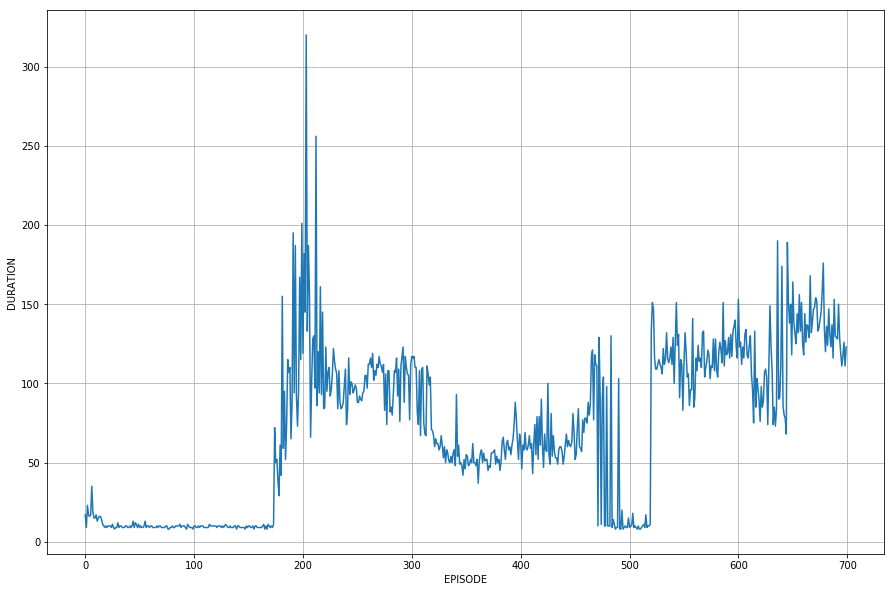

In [12]:
plot_durations()

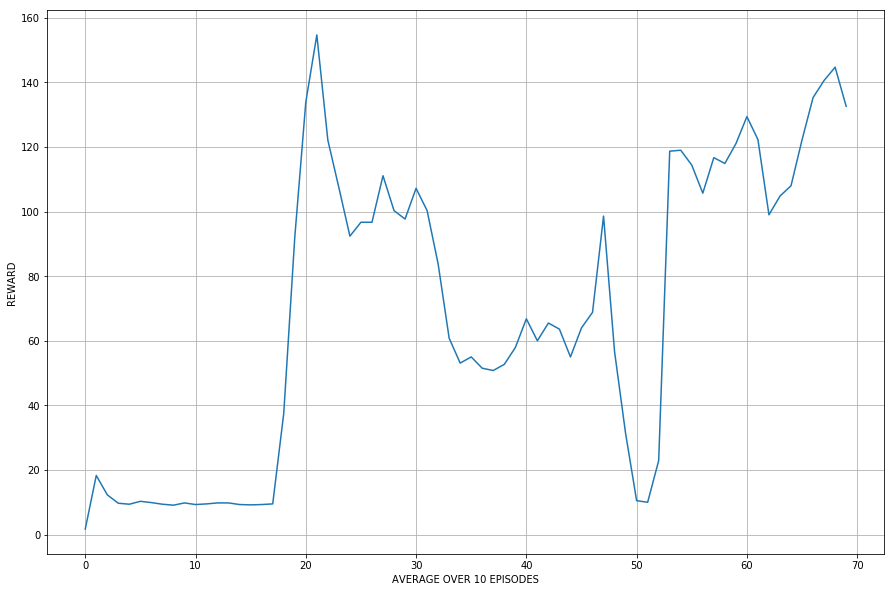

In [13]:
def plot_rewards():
    plt.figure(figsize=(15,10))
    plt.xlabel('AVERAGE OVER 10 EPISODES')
    plt.ylabel('REWARD')
    plt.plot(REWARDS)
    plt.grid()
    plt.show()
plot_rewards()

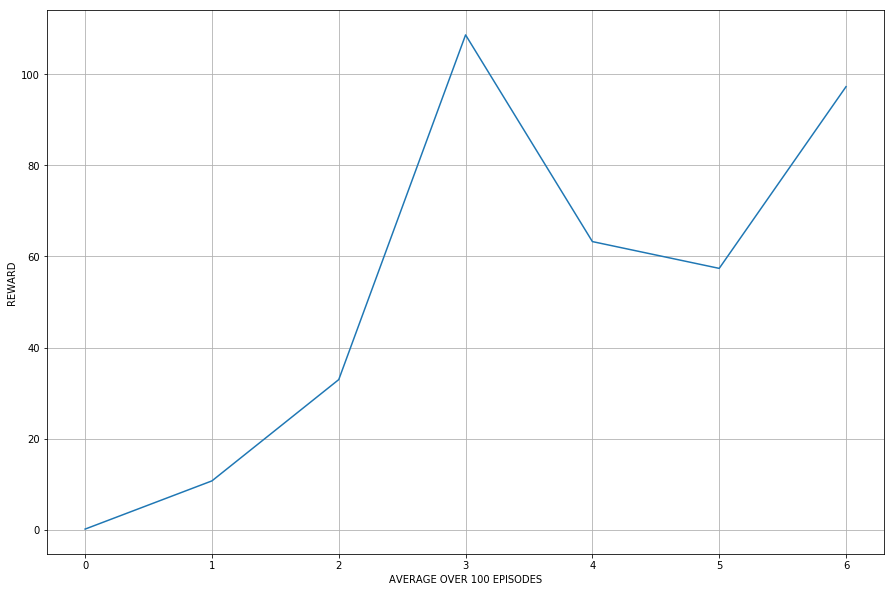

In [15]:
def plot_rewards():
    plt.figure(figsize=(15,10))
    plt.xlabel('AVERAGE OVER 100 EPISODES')
    plt.ylabel('REWARD')
    plt.plot(AVG_OVER_100)
    plt.grid()
    plt.show()
plot_rewards()

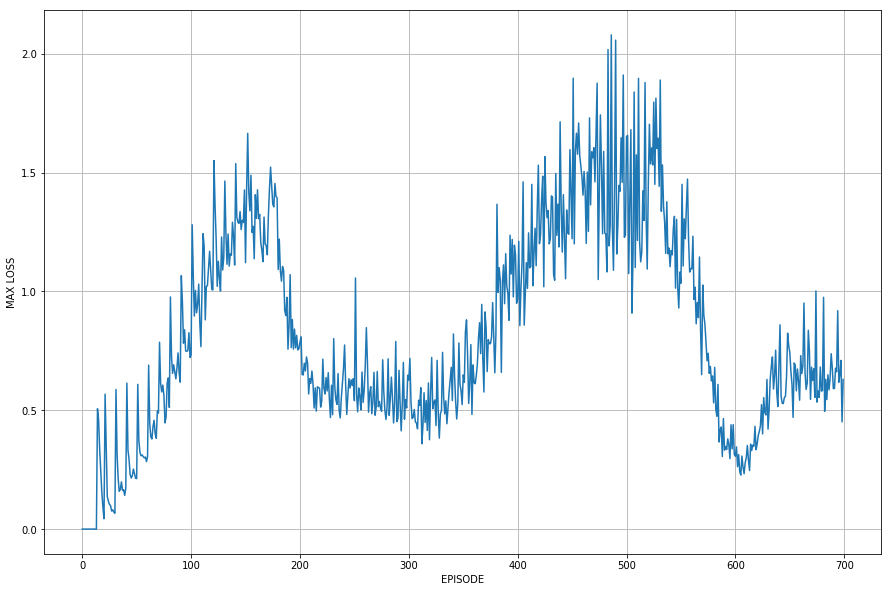

In [14]:
def plot_loss():
    plt.figure(figsize=(15,10))
    plt.xlabel('EPISODE')
    plt.ylabel('MAX LOSS')
    plt.plot(MAX_LOSS)
    plt.grid()
    plt.show()
plot_loss()